# Daily Versus Hourly Particle Flows

In [1]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation
from datetime import datetime, timedelta
# from dateutil.parser import parse
from IPython.display import HTML
from salishsea_tools import nc_tools, places

from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, AdvectionRK4_3D
#Field,VectorField, AdvectionRK4,


%matplotlib inline

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2919/libparcels_random_c742689d-d670-4268-8402-7dd9d9f45f34.so


In [2]:
# Paths and filenames
paths = {
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    'grid': '/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc',
    'results': './results',
}

### Functions

In [3]:
def fieldset_from_nemo(daterange, coords, res, version, flat=True):
    """Generate a fieldset from a hourly SalishSeaCast forcing fields
    over daterange.
    """

    # Generate sequential list of forcing file prefixes
    prefixes = [
        nc_tools.get_hindcast_prefix(daterange[0] + timedelta(days=d), res, version)
        for d in range(np.diff(daterange)[0].days + 1)
    ]

    # Predefine fieldset argument dictionaries
    filenames, variables, dimensions = {}, {}, {}

    # Define dict fields for each variable
    for var, name in zip(['U', 'V', 'W'], ['vozocrtx', 'vomecrty', 'vovecrtz']):
        
        # Exclude vertical velocity if 2D
        if flat:
            if var == 'W': break

        # Dict of filenames containing the coordinate and forcing variables
        datafiles = [prefix + f'_grid_{var}.nc' for prefix in prefixes]
        filenames[var] = {'lon': coords, 'lat': coords, 'data': datafiles}

        # NEMO variable name
        variables[var] = name

        # Dict of NEMO coordinate names (f-points)
        dimensions[var] = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
        
        # Add depth fields if 3D (f-points are on W grid)
        if not flat:
            filenames[var]['depth'] = prefixes[0] + '_grid_W.nc'
            dimensions[var]['depth'] = 'depthw'

    # Load NEMO forcing into fieldset
    field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)# field_chunksize='auto')
    
    return field_set

In [4]:
def DeleteParticle(particle, fieldset, time):
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

## HOURLY

In [5]:
# Define release parameters
location = 'Central SJDF'
n = 10   # number of particles
r = 50   # radius of particle cloud [m]

# Start time, duration and timestep
start = datetime(2019, 3, 1, 0, 0, 0)
duration = timedelta(days=30)
dt = 3600#timedelta(seconds=90)

# Create Gaussian distribution around release point
mean, cov = [0, 0], [[r**2, 0], [0, r**2]]
x_offset, y_offset = np.random.multivariate_normal(mean, cov, n).T
lon, lat = places.PLACES[location]['lon lat']
lons = lon + x_offset / 111000 / np.cos(np.deg2rad(lat))
lats = lat + y_offset / 111000

# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 125.
zvals = dmin + np.random.random_sample(n)*(dmax-dmin)

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

In [6]:
# Set output file name.  Maybe change for each run
fn = f'HOURLY_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['results'], fn)
print(outfile)

./results/HOURLY_20190301_20190331.nc


In [7]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'], 'h', '201812', flat=False) #flat=False forces it to care about bathymetry

         It will be opened with no decoding. Filling values might be wrongly parsed.


In [8]:
# Execute NEMO-only, 3D run, release at 5m
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lons, lat=lats, depth=zvals, time=np.repeat(start, n))

pset.execute(
    pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-2919/ca66bef8020e89a7766f3605a6e9859e_0.so
INFO: Temporary output files are stored in ./results/out-ODBGUVUS.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-ODBGUVUS" to convert these to a NetCDF file during the run.
 32% (842400.0 of 2592000.0) |###        | Elapsed Time: 0:08:29 ETA:   0:16:49

Particle 5 lost !! [-124.77168277294784, 48.49235146865911, 11.442100372894373, 927000.0]


 39% (1018800.0 of 2592000.0) |###       | Elapsed Time: 0:10:22 ETA:   0:19:03

Particle 6 lost !! [-124.79233951841287, 48.51395672353511, 59.467085309288734, 1101600.0]


 39% (1022400.0 of 2592000.0) |###       | Elapsed Time: 0:10:25 ETA:   0:19:52

Particle 1 lost !! [-124.79357563340615, 48.52364254548561, 49.00405878028059, 1105200.0]


 44% (1144800.0 of 2592000.0) |####      | Elapsed Time: 0:11:39 ETA:   0:14:33

Particle 9 lost !! [-123.48922493425307, 48.282296728780615, 49.68229995469551, 1227600.0]


 46% (1206000.0 of 2592000.0) |####      | Elapsed Time: 0:12:16 ETA:   0:14:39

Particle 8 lost !! [-124.87476088442247, 48.612072816461705, 19.427284562044235, 1288800.0]


 70% (1825200.0 of 2592000.0) |#######   | Elapsed Time: 0:18:43 ETA:   0:07:47

Particle 0 lost !! [-124.83080818548876, 48.567762154435336, 13.509738530600345, 1908000.0]


100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:26:35 Time:  0:26:35


In [7]:
# Had this cell earlier before but seem to need to run it after simulationto get the outputfiles 
# from the temp directory into my final outfile
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
grid = xr.open_dataset(paths['grid'])

In [8]:
data = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

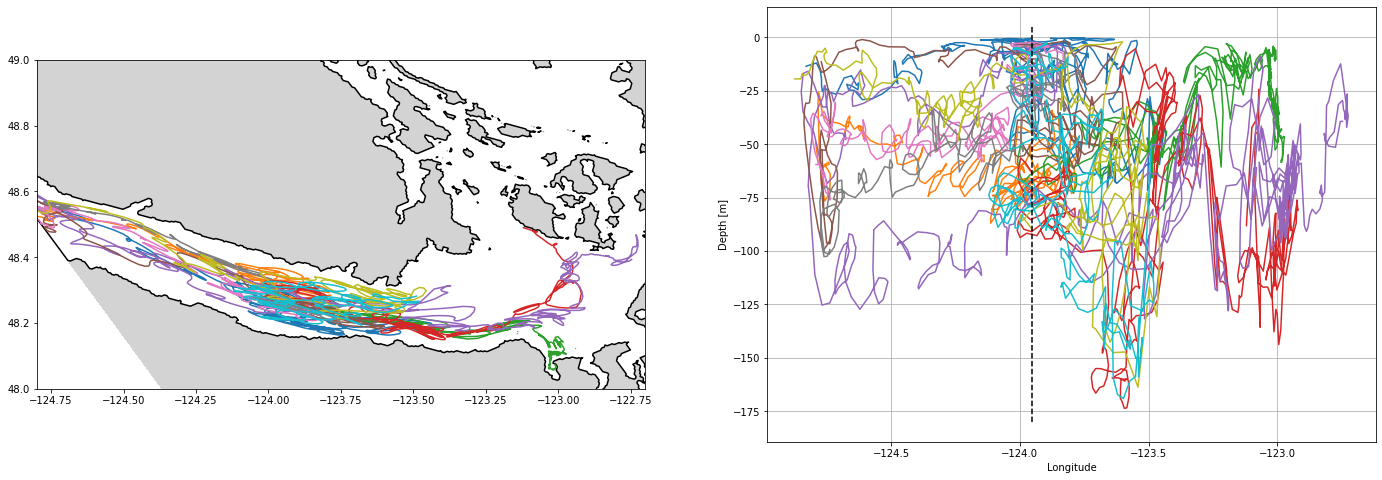

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax[0].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax[0].set_xlim([-124.8, -122.7])
ax[0].set_ylim([48, 49])
ax[0].set_aspect(5/4.4)
nmin, nmax = 0, -1
for traj in range(n):
    s = ax[0].plot(data.lon[traj, nmin:nmax], data.lat[traj, nmin:nmax])
ax[0].scatter(lon,lat,c='k', marker='*', linewidths=8)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

nmax = -1
for traj in range(n):
    s = ax[1].plot(data.lon[traj, nmin:nmax], -data.z[traj, nmin:nmax])
ax[1].grid()
ax[1].plot([lon,lon],[5,-180],'k--')
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Longitude')

## DAILY

In [ ]:
# Define release parameters
location = 'Central SJDF'
n = 10   # number of particles
r = 50   # radius of particle cloud [m]

# Start time, duration and timestep
start = datetime(2019, 3, 1, 0, 0, 0)
duration = timedelta(days=30)
dt = 86400#timedelta(seconds=90)

# Create Gaussian distribution around release point
mean, cov = [0, 0], [[r**2, 0], [0, r**2]]
x_offset, y_offset = np.random.multivariate_normal(mean, cov, n).T
lon, lat = places.PLACES[location]['lon lat']
lons = lon + x_offset / 111000 / np.cos(np.deg2rad(lat))
lats = lat + y_offset / 111000

# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 125.
zvals = dmin + np.random.random_sample(n)*(dmax-dmin)

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

In [ ]:
# Set output file name.  Maybe change for each run
fn = f'DAILY_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['results'], fn)
print(outfile)

In [14]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'], 'd', '201812', flat=False) #flat=False forces it to care about bathymetry

In [15]:
# Execute NEMO-only, 3D run, release at 5m
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lons, lat=lats, depth=zvals, time=np.repeat(start, n))

pset.execute(
    pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-2919/8599b262a85cf997653f41a5e1c20a3b_0.so
INFO: Temporary output files are stored in ./results/out-BNQWLRAY.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-BNQWLRAY" to convert these to a NetCDF file during the run.
 23% (604800.0 of 2592000.0) |##         | Elapsed Time: 0:00:29 ETA:   0:02:44

Particle 11 lost !! [-124.74308758709094, 48.468080653800264, 20.63349706644899, 644400.0]


 28% (738000.0 of 2592000.0) |###        | Elapsed Time: 0:00:39 ETA:   0:11:03

Particle 18 lost !! [-123.81554447751549, 48.35657765219072, 5.682615926071946, 777600.0]


 44% (1155600.0 of 2592000.0) |####      | Elapsed Time: 0:01:05 ETA:   0:01:02

Particle 15 lost !! [-123.53305522081166, 48.312557136510414, 5.817645014790742, 1195200.0]


 50% (1317600.0 of 2592000.0) |#####     | Elapsed Time: 0:01:16 ETA:   0:00:55

Particle 10 lost !! [-124.78648664606943, 48.50712268505251, 35.02918258719046, 1357200.0]


 81% (2106000.0 of 2592000.0) |########  | Elapsed Time: 0:02:08 ETA:   0:00:21

Particle 17 lost !! [-124.73838049152153, 48.44961393032287, 120.42784742678009, 2145600.0]


 83% (2160000.0 of 2592000.0) |########  | Elapsed Time: 0:02:12 ETA:   0:00:37

Particle 13 lost !! [-124.77753599171342, 48.49630532808189, 40.7013057948611, 2199600.0]


100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:02:40 Time:  0:02:40


In [ ]:
# Had this cell earlier before but seem to need to run it after simulationto get the outputfiles 
# from the temp directory into my final outfile
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
grid = xr.open_dataset(paths['grid'])

In [ ]:
data = xr.open_dataset(outfile)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax[0].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax[0].set_xlim([-124.8, -122.7])
ax[0].set_ylim([48, 49])
ax[0].set_aspect(5/4.4)
nmin, nmax = 0, -1
for traj in range(n):
    s = ax[0].plot(data.lon[traj, nmin:nmax], data.lat[traj, nmin:nmax])
ax[0].scatter(lon,lat,c='k', marker='*', linewidths=8)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

nmax = -1
for traj in range(n):
    s = ax[1].plot(data.lon[traj, nmin:nmax], -data.z[traj, nmin:nmax])
ax[1].grid()
ax[1].plot([lon,lon],[5,-180],'k--')
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Longitude')

quite visible, even from this simple run in Ocean Parcels instead of Ariane that the daily average of the flows decreses the amount of particles that get deeper into the salish sea